In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import pickle

2025-02-22 19:28:41.014268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 19:28:41.025183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 19:28:41.038249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 19:28:41.041797: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 19:28:41.051344: I tensorflow/core/platform/cpu_feature_guar

In [3]:
with open('novel.txt', 'r', encoding='utf-8') as file:
    text = file.read()
print('corpus length:', len(text))

corpus length: 581888


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
text = text.lower()  
tokenizer.fit_on_texts([text])

unique_word_index = tokenizer.word_index  
vocab_size = len(unique_word_index) + 1 
words = text_to_word_sequence(text)
unique_words = np.unique(words)
print(f"Total Words: {vocab_size}")

Total Words: 8932


In [5]:
words[:7]

['\ufeff', 'project', "gutenberg's", 'the', 'adventures', 'of', 'sherlock']

In [6]:
WORD_LENGTH = 5
X = []
Y = []
for i in range(len(words) - WORD_LENGTH):
    sequence = words[i:i + WORD_LENGTH]
    X.append(' '.join(sequence))
    Y.append(words[i + WORD_LENGTH])

X_indices = np.zeros((len(X), WORD_LENGTH), dtype=np.int32)
Y_indices = np.zeros((len(Y)), dtype=np.int32)

for i, seq in enumerate(X):
    words_in_seq = seq.split()
    for j, word in enumerate(words_in_seq):
        X_indices[i, j] = tokenizer.word_index[word]
    Y_indices[i] = tokenizer.word_index[Y[i]]

In [7]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=WORD_LENGTH),
    Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)),  
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
]) 

learning_rate = 0.001
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer="adam",
    metrics=['accuracy']
)

model.build(input_shape=(None, WORD_LENGTH))

model.summary()

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1740245357.626609   53984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740245357.673854   53984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740245357.676632   53984 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at htt

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 5, 128)         │     1,143,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8932)           │     4,582,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,513,892 (24.85 MB)

 Trainable params: 6,513,892 (24.85 MB)

 Non-trainable params: 0 (0.00 B)

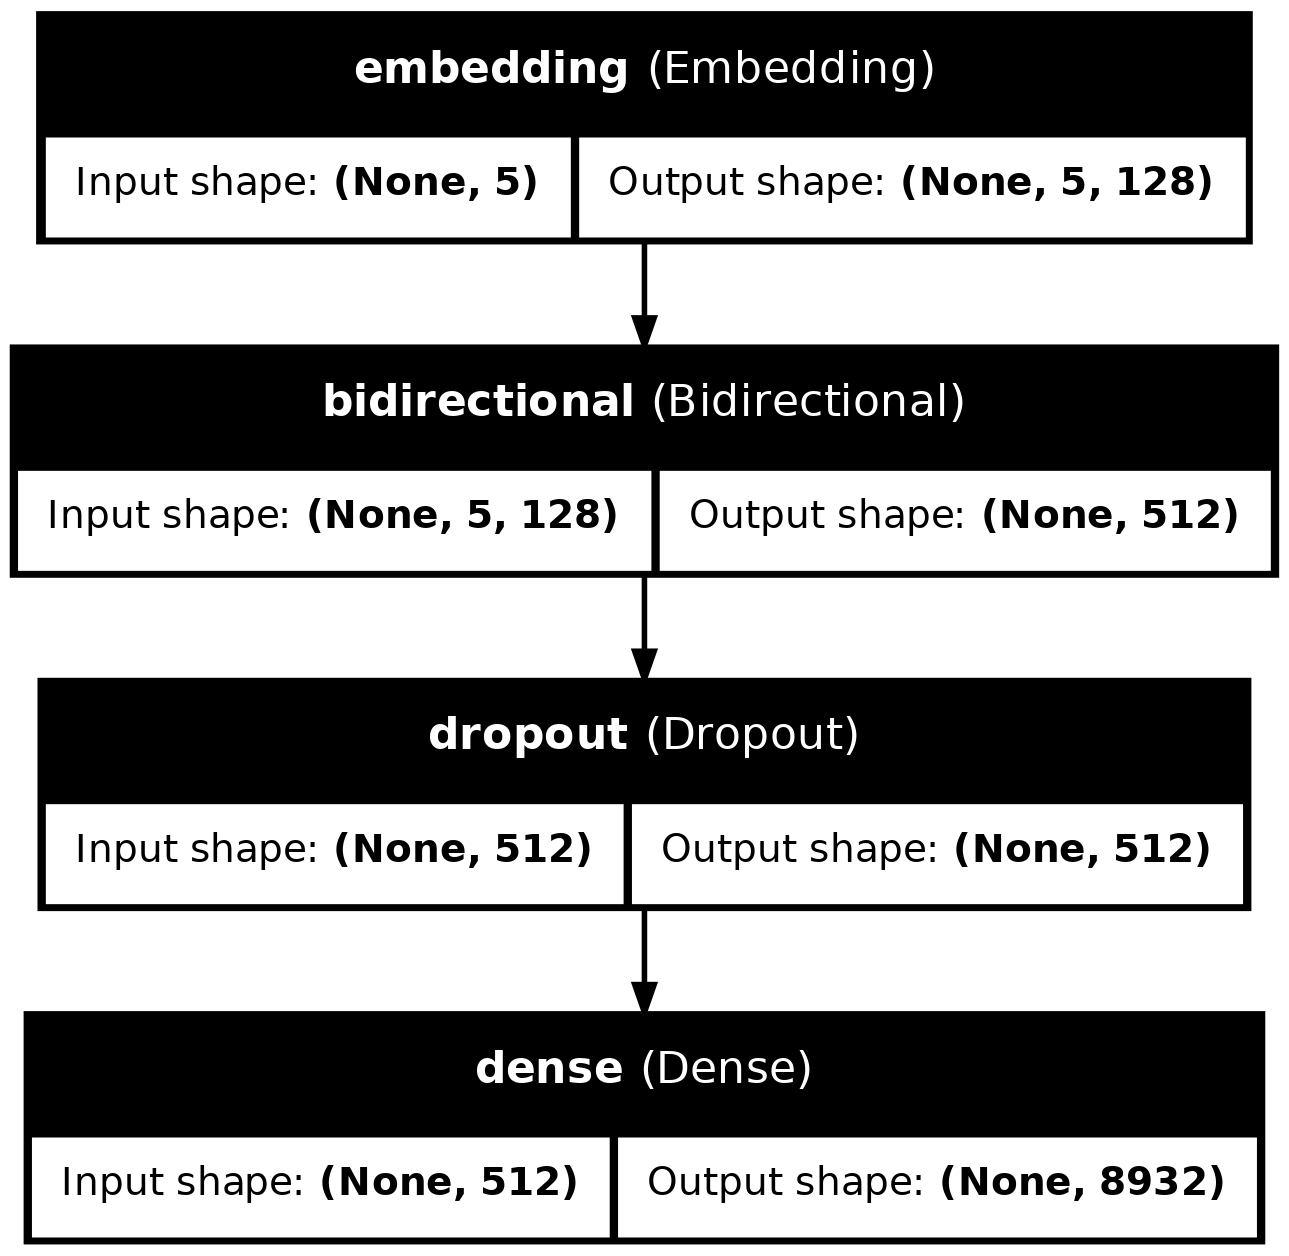

In [8]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

plot_model(model, to_file='next_word_model_structure.png', show_shapes=True, show_layer_names=True)

In [10]:
lr_scheduler = ReduceLROnPlateau(
    monitor='loss',  
    factor=0.5,          
    patience=5,           
    min_lr=1e-6,     
    verbose=1
)

early_stopping = EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    X_indices, Y_indices,
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping, lr_scheduler]  
).history

Epoch 1/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.0505 - loss: 6.8867 - learning_rate: 0.0010
Epoch 2/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.0964 - loss: 5.8731 - learning_rate: 0.0010
Epoch 3/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.1319 - loss: 5.4367 - learning_rate: 0.0010
Epoch 4/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.1525 - loss: 5.1016 - learning_rate: 0.0010
Epoch 5/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.1647 - loss: 4.8230 - learning_rate: 0.0010
Epoch 6/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.1799 - loss: 4.5421 - learning_rate: 0.0010
Epoch 7/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.1945 - loss: 4.3030 - learning_rate: 0.0010
Epoch 8/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.2164 - loss: 4.0276 - learning_rate: 0.0010
Epoch 9/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.2376 - loss: 3.7888 - learn

In [ ]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

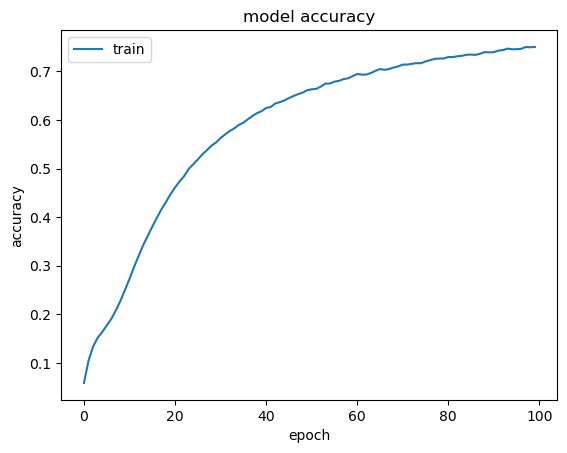

In [13]:
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

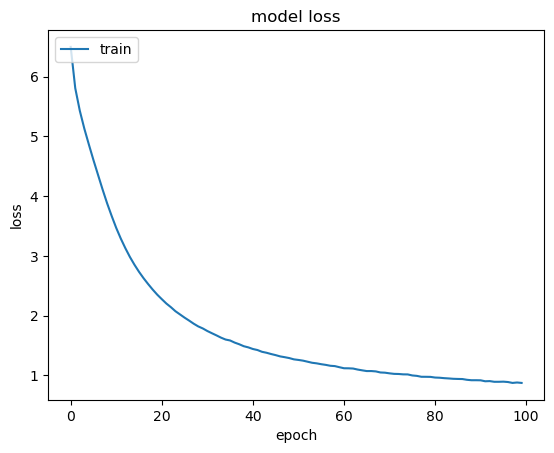

In [14]:
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

In [10]:
import heapq

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

def prepare_input(text):
    input_words = text_to_word_sequence(text.lower())[-WORD_LENGTH:]
    x = np.zeros((1, WORD_LENGTH), dtype=np.int32)
    for i, word in enumerate(input_words):
        x[0, i] = tokenizer.word_index.get(word, 0)
    return x

def predict_completions(text, n=3, max_words=5):
    indices_word = {v: k for k, v in tokenizer.word_index.items()}
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    
    completions = []
    for idx in next_indices:
        current_text = text.lower()
        completion = []
        for _ in range(max_words):
            x = prepare_input(current_text)
            preds = model.predict(x, verbose=0)[0]
            next_idx = sample(preds, 1)[0]
            next_word = indices_word.get(next_idx, '')
            completion.append(next_word)
            current_text = ' '.join((current_text.split() + [next_word])[-WORD_LENGTH:])
        completions.append(' '.join(completion))
    return completions

In [ ]:
seq = "Well, I followed you to your door, and so made sure".lower()
print(seq)
print(predict_completions(seq, 1))
print()

well, i followed you to your door, and so made sure
['that i was really an']

